In [67]:
import numpy as np
import script.model.bonds as bd
import script.model.model as sim
import script.model.utility as utl
import copy
import scipy.special as spe
from importlib import reload
import matplotlib.pyplot as plt

from scipy.special import binom


from scipy.integrate import quad


def getFig(figsize=(4, 3), xlab="", ylab=""):
    fig, ax = plt.subplots(figsize=(5,4), dpi=100)
    if xlab:
        ax.set_xlabel(xlab)
    if ylab:
        ax.set_ylabel(ylab)
    return ax
tB = 1e-10

## analytical results

In [74]:
kT = 4.14
x1 = 1.5
x2 = 2.0

def eta(ta, tb, f):
    return tb/(ta*np.exp(-f*(x1-x2)/kT)+tb)

def tau(ta, tb,f):
    return ta*np.exp(-f*x1/kT)*eta(ta, tb, f)

def rm(i, ta, tb, f):
    return i*(np.exp(f*x1/(i*kT))/ta + np.exp(f*x2/(i*kT))/tb)

def drm(i, ta, tb, f):
    return  i*(np.exp(f*x2/(i*kT))/tb)/rm(i, ta, tb, f)**2

def gm(i, n0, ton):
    return (n0-i)/ton


def lifetime_ana(n0, ta, tb, F, ton=0):
    ave = 0
    for i in range(1, n0+1):
        ave += tau(ta, tb, F/i)/i
    
    #print("ave0=", ave)
    #print("gm(1)=", gm(1,n0, ton))
    #print("rm(1)=", rm(5, ta, tb, F))
    ave0 = ave
    for i in range(1, n0):
        for j in range(i+1, n0+1):
            num, denom = 1, 1
            if j-i>=j:
                num = 0
            for k in range(j-i, j):
                num = num*gm(k, n0, ton)
                flag=True
            for k in range(j-i, j+1):
                denom = denom*rm(k, ta, tb, F)
            #print(ave)
            ave += num/denom
    return ave


def lifetime_sens(n0, ta, tb, F, ton, dt=1.1):
    t1 = lifetime_ana(n0, ta, tb, F, ton)
    t2 =lifetime_ana(n0, ta, tb*1.1, F,ton)
    return (np.log(t2)-np.log(t1))/0.1

def lifetime_sens_ana(n0,ta,tb,F,ton):
    sens= 0
    for i in range(1, n0+1):
        sens += drm(i, ta, tb, F)
        
    for i in range(1, n0):
        for j in range(i+1, n0+1):
            num, denom = 1, 1
            if j-i>=j:
                num = 0
            for k in range(j-i, j):
                num = num*gm(k, n0, ton)
                flag=True
            
            for k in range(j-i, j+1):
                denom = denom*rm(k, ta, tb, F)
                
            dev = 0
            for k in range(j-i, j+1):
                dev += (1- eta(ta, tb, F/k))/k
            #print(ave)
            sens += num*dev/denom   
    
    return sens/lifetime_ana(n0, ta, tb, F, ton)

def lifetime_xi(n0, ta, tb, F, ton):
    return lifetime_sens(n0, ta, tb, F, ton)/lifetime_std_ana(n0, ta, tb, F, ton)

def lifetime_std_ana(n0, ta, tb, F, ton):
    ### calculate product gm i, j
    phi = np.zeros((n0+1, n0+1))
    
    for i in range(1, n0+1):
        for j in range(i+1, n0+1):
            num, denom = 1, 1
            if i>= j:
                num =0
            for k in range(i, j):
                num =num*gm(k, n0, ton)
            for k in range(i, j+1):
                denom = denom*rm(k, ta, tb, F)
            phi[i, j] = num/denom
    
    ## find the mean lifetime list
    T_ave_list = np.zeros(n0+1)
    for n in range(1, n0+1):
        t_ave = 0
        for i in range(1, n+1):
            t_ave += 1.0/rm(i, ta, tb, F)
            
            for j in range(i+1, n0+1):
                t_ave += phi[i, j]
                
        T_ave_list[n] = t_ave
    #print(T_ave_list)
    #print("lifetime=", T_ave_list[n0])

    ### calculate the variance
    T_std = 0
    for i in range(1, n0+1):
        T_std += 2*T_ave_list[i]/rm(i, ta, tb, F)
        
        for j in range(i+1, n0+1):
            T_std +=2*T_ave_list[j]*phi[i,j]
    #print("std =", np.sqrt(T_std-T_ave_list[n0]**2)/T_ave_list[n0])
    return np.sqrt(T_std-T_ave_list[n0]**2)/T_ave_list[n0]


In [75]:
def convert_to_acc(xilist, de):
    xi = np.asarray(xilist)
    return 0.5+xi*de/(2*np.sqrt(3.1416))

# Calculate the accuracy

In this notebook, I will study how the interference affect the error in discrimination. The accuracy is defined as the probability to make correct descision when discriminate two BCRs with different affinities, that is ranking the high affinity one higher than the low affinity one. 

For example, in the case of T classifier, considering a B cell with affinity 20kT had cluster lifetime 10s whereas another B cell with lower affinity 18kT constracted a cluster lasting 12s, we call it a "mistake". We randomly draw two samples from two distributions (one corresponds to the good B cell and the other is determined by the bad B cell affinity), then we compare those two samples. The error is the probability for a "mistake" to happen. Then the accuracy is just 1-error



In [5]:
reload(sim)

pass

In [70]:
def GetAcc(eb_list, prm, n=200, output=False, num_competes=1):
    """
        args:
            eb_list: affinity distribution of B cells
            prm: default parameter (fixing other parameters)
            n: number of trails
        return:
            acc: the probability to rank the best B cell highest
    """
    nacc_count = 0
    tacc_count = 0
    nacc_pos_comp_count = 0
    best_id = np.argmax(eb_list)
    
    num_cell = len(eb_list)
    sto_list = []
    for i, eb in enumerate(eb_list):
        sto_list.append(sim.Stoch(copy.deepcopy(prm)))
        sto_list[i].prm_dict["elist"][1] = eb
        sto_list[i].setup()
        sto_list[i].loadSharing=False
    if output:
        print("*"*15)
        print("init complete")
        print("eblist", eb_list)
        print("best id=", best_id)
        print("check eb:", end="  ")
        for stoi in sto_list:
            print("{0:.2f}".format(stoi.bonds.elist[1]), end=", ")
        print("")
    for i in range(n):
        nag_list = np.zeros(num_cell)
        tend_list = np.zeros(num_cell)
        nag_post_comp_list = np.zeros(num_cell)
        if output and i>1:
            sim.printProgress(i, n)
        for j, stoi in enumerate(sto_list):
            stoi.setup()
            nag, tend = stoi.run1(output=False, storeData=False)
            nag_list[j] = nag[0]
            tend_list[j]= tend
            if np.isnan(nag[0]):
                print("simulation not finished!")
                return np.nan, np.nan
        if best_id == np.random.choice(np.flatnonzero(nag_list == nag_list.max())): #np.argmax(nag_list):
            nacc_count += 1

        if best_id == np.argmax(tend_list):
            tacc_count += 1
            
        # inter B cell competition
        for _ in range(num_competes):
            sto1, sto2 = np.random.choice(sto_list, size=2, replace=False)
            sto1.extract_from_another_bcell(sto2)
        for j, stoi in enumerate(sto_list):
            nag_post_comp_list[j] = stoi.nags[0]
        if best_id == np.random.choice(np.flatnonzero(
            nag_post_comp_list == nag_post_comp_list.max()
        )):
            nacc_pos_comp_count +=1
        
        if output and i==1:
            print("example 1:")
            print("nag_list=", nag_list)
            print("tendlist=", tend_list)
            print("nag_post_comp_list = ", nag_post_comp_list)
    
    if output:
        print("")
        print("nacc_count=", nacc_count, ", tacc_count=", tacc_count, ", nacc_post_count=",nacc_pos_comp_count )
    return nacc_count / n, tacc_count / n, nacc_pos_comp_count / n
def positive_rate(nc, x, n):
    s = 0
    for i in range(nc, n+1):
        s += spe.binom(n, i)*x**i/(1+x)**n
    return s

def acc_n(x, n, alpha):
    s = 0
    for nc in range(n+1):
        s += (positive_rate(nc, alpha*x, n) - positive_rate(nc + 1, alpha*x, n)) *\
        (positive_rate(nc, x, n) + positive_rate(nc + 1, x, n))/2.0
    return s

def tau(ta, tb, f=0, xa=1.5, xb=2.0):
    return ta*tb*np.exp(-f*(xa+xb)/4.012)/(ta*np.exp(-f*xa/4.012) + tb*np.exp(-f*xb/4.012))

def acc_t(x, n, alpha):
    def integrand(y):
        r = tau(1, alpha*x)/tau(1, x)
        return (1-y**r)**n * (1-y)**(n-1)
    
    return 1- n*(quad(integrand, 0, 1)[0])


class scan_eb1:
    
    def __init__(self, n=200):
        self.numRun = n
        self.init_dis = "random" ## or fixed
        self.prmlist = []
        self.nerror_list, self.nerror_std_list = [], []
        self.terror_list, self.terror_std_list = [], []
        self.n2error_list, self.n2error_std_list = [], []
        pass
    
    def run_eb(self, prm, eblist = np.arange(0, 11, 1), dE=0.2, num_cell=5, output=False):
        for eb in eblist:
            self._run(prm, eb, dE, num_cell, output=output)
            self.prmlist.append(eb)
        #return self.prmlist, self.nerror_list, self.nerror_std_list, self.terror_list, self.terror_std_list
        return
    
    def _run(self, prm, eb, dE, num_cell, num_run = 10, output=False):
        nerror_tmp, terror_tmp, n2error_tmp = [], [], []
        if self.init_dis=="fixed":
            eb_distribution =[eb]*(num_cell-1) + [eb+dE]
        elif self.init_dis == "uniform":
            eb_distribution = np.linspace(eb-dE, eb, num_cell)
        for j in range(num_run):
            if self.init_dis=="random":
                eb_distribution = np.random.normal(eb, dE, num_cell)
            sim.printProgress(j, num_run)
            nerror, terror, n2error = GetAcc(eb_distribution, prm, n= self.numRun, output=output)
            nerror_tmp.append(nerror)
            terror_tmp.append(terror)
            n2error_tmp.append(n2error)
        
        self.nerror_list.append(np.mean(nerror_tmp))
        self.nerror_std_list.append(np.std(nerror_tmp))
        self.terror_list.append(np.mean(terror_tmp))
        self.terror_std_list.append(np.std(terror_tmp))
        self.n2error_list.append(np.mean(n2error_tmp))
        self.n2error_std_list.append(np.std(n2error_tmp))
        print("eb1={0:.2f}, de={5:.2f}, n acc={1:.3f}[{3:.3f}], t acc={2:.3f}[{4:.3f}], n2 acc={6:.3f}[{7:.4f}]".
                  format(
                      eb, np.mean(nerror_tmp),np.mean(terror_tmp), np.std(nerror_tmp),np.std(terror_tmp), dE,
                      np.mean(n2error_tmp), np.std(n2error_tmp)
                  ))
        return
    
    def run_de(self, prm, delist = np.linspace(0, 1, 11), eb=5, num_cell = 5, output=False):
        
        for de in delist:
            self._run(prm, eb, de, num_cell, output=output)
            self.prmlist.append(de)
        return
    
    def run_nb(self, prm, nBlist = np.arange(2, 15, 1, dtype=int), eb=5, dE=0.3, output=False):
        for nb in nBlist:
            self._run(prm, eb, dE, nb, output=output)
            self.prmlist.append(nb)
        return

In [49]:

prm0 = sim.prm_dict.copy()
prm0["scheme"] = "step"
prm0["tc"] = 0
prm0["l0_list"] = [100, 0]
prm0["f0"] = 10 
prm0["elist"] = [10, 10, 10, 10]
prm0["ton"] = 1e20

seE10 = scan_eb1()
seE10.numRun = 400
seE10.init_dis = "random"
seE10.run_eb(prm0, eblist = np.arange(0.5, 16.5, 1), num_cell=10, dE=0.1)


eb1=0.50, de=0.10, n accuracy=0.114[0.011], t accuracy=0.186[0.020]
eb1=1.50, de=0.10, n accuracy=0.104[0.015], t accuracy=0.234[0.079]
eb1=2.50, de=0.10, n accuracy=0.099[0.005], t accuracy=0.212[0.044]
eb1=3.50, de=0.10, n accuracy=0.107[0.011], t accuracy=0.226[0.074]
eb1=4.50, de=0.10, n accuracy=0.112[0.019], t accuracy=0.208[0.039]
eb1=5.50, de=0.10, n accuracy=0.112[0.017], t accuracy=0.233[0.051]
eb1=6.50, de=0.10, n accuracy=0.124[0.016], t accuracy=0.225[0.055]
eb1=7.50, de=0.10, n accuracy=0.135[0.024], t accuracy=0.190[0.059]
eb1=8.50, de=0.10, n accuracy=0.180[0.039], t accuracy=0.218[0.054]
eb1=9.50, de=0.10, n accuracy=0.216[0.038], t accuracy=0.191[0.027]
eb1=10.50, de=0.10, n accuracy=0.280[0.123], t accuracy=0.185[0.054]
eb1=11.50, de=0.10, n accuracy=0.244[0.041], t accuracy=0.141[0.020]
eb1=12.50, de=0.10, n accuracy=0.204[0.033], t accuracy=0.114[0.014]
eb1=13.50, de=0.10, n accuracy=0.191[0.038], t accuracy=0.112[0.018]
eb1=14.50, de=0.10, n accuracy=0.150[0.022],

In [60]:
prm0["l0_list"] = [200, 0]
prm0["f0"] = 0
seE5 = scan_eb1()
seE5.numRun = 4
seE5.init_dis = "fixed"
seE5.run_eb(prm0, eblist = np.arange(4, 16.5, 0.5), num_cell=5, dE=0.1)


eb1=1.00, de=0.10, n accuracy=0.150[0.166], t accuracy=0.275[0.236]
eb1=2.00, de=0.10, n accuracy=0.175[0.225], t accuracy=0.425[0.160]
eb1=3.00, de=0.10, n accuracy=0.125[0.168], t accuracy=0.275[0.236]
eb1=4.00, de=0.10, n accuracy=0.300[0.187], t accuracy=0.350[0.200]
eb1=5.00, de=0.10, n accuracy=0.250[0.194], t accuracy=0.200[0.187]
eb1=6.00, de=0.10, n accuracy=0.175[0.195], t accuracy=0.325[0.160]
eb1=7.00, de=0.10, n accuracy=0.200[0.100], t accuracy=0.250[0.194]
eb1=8.00, de=0.10, n accuracy=0.275[0.175], t accuracy=0.275[0.236]
eb1=9.00, de=0.10, n accuracy=0.275[0.236], t accuracy=0.175[0.195]
eb1=10.00, de=0.10, n accuracy=0.325[0.195], t accuracy=0.225[0.236]
eb1=11.00, de=0.10, n accuracy=0.500[0.250], t accuracy=0.150[0.166]
eb1=12.00, de=0.10, n accuracy=0.275[0.208], t accuracy=0.200[0.150]
eb1=13.00, de=0.10, n accuracy=0.275[0.236], t accuracy=0.225[0.175]
eb1=14.00, de=0.10, n accuracy=0.300[0.218], t accuracy=0.225[0.175]
eb1=15.00, de=0.10, n accuracy=0.125[0.202]

In [104]:
prm0 = sim.prm_dict.copy()
prm0["scheme"] = "step"
prm0["tc"] = 0
prm0["l0_list"] = [200, 0]
prm0["f0"] = 16.56 
prm0["elist"] = [8, 10, 10, 10]
prm0["ton"] = 1e20

seE2 = scan_eb1()
seE2.numRun = 2000
seE2.init_dis = "fixed"
seE2.run_eb(prm0, eblist = np.arange(5, 16.5, 0.5), num_cell=2, dE=0.1)



eb1=5.00, de=0.10, n acc=0.532[0.011], t acc=0.637[0.012], n2 acc=0.530[0.0104]
eb1=5.50, de=0.10, n acc=0.541[0.007], t acc=0.626[0.008], n2 acc=0.549[0.0127]
eb1=6.00, de=0.10, n acc=0.557[0.009], t acc=0.635[0.011], n2 acc=0.554[0.0084]
eb1=6.50, de=0.10, n acc=0.566[0.009], t acc=0.637[0.009], n2 acc=0.570[0.0104]
eb1=7.00, de=0.10, n acc=0.584[0.009], t acc=0.630[0.009], n2 acc=0.591[0.0143]
eb1=7.50, de=0.10, n acc=0.606[0.013], t acc=0.626[0.009], n2 acc=0.610[0.0094]
eb1=8.00, de=0.10, n acc=0.636[0.007], t acc=0.623[0.006], n2 acc=0.640[0.0152]
eb1=8.50, de=0.10, n acc=0.653[0.013], t acc=0.612[0.007], n2 acc=0.666[0.0041]
eb1=9.00, de=0.10, n acc=0.675[0.008], t acc=0.598[0.005], n2 acc=0.703[0.0076]
eb1=9.50, de=0.10, n acc=0.682[0.012], t acc=0.585[0.015], n2 acc=0.729[0.0094]
eb1=10.00, de=0.10, n acc=0.695[0.008], t acc=0.569[0.011], n2 acc=0.763[0.0066]
eb1=10.50, de=0.10, n acc=0.687[0.009], t acc=0.554[0.010], n2 acc=0.790[0.0071]
eb1=11.00, de=0.10, n acc=0.674[0.012]

In [11]:
reload(sim)
prm0 = sim.prm_dict.copy()
prm0["scheme"] = "step"
prm0["tc"] = 0
prm0["l0_list"] = [100, 0]
prm0["f0"] = 10 
prm0["elist"] = [10, 10, 10, 10]
prm0["ton"] = 1e20


eb1=5.00, de=0.10, n acc=0.541[0.020], t acc=0.633[0.024], n2 acc=0.535[0.0277]
eb1=5.50, de=0.10, n acc=0.548[0.023], t acc=0.634[0.014], n2 acc=0.539[0.0143]
eb1=6.00, de=0.10, n acc=0.551[0.018], t acc=0.642[0.016], n2 acc=0.551[0.0230]
eb1=6.50, de=0.10, n acc=0.564[0.020], t acc=0.637[0.032], n2 acc=0.574[0.0280]
eb1=7.00, de=0.10, n acc=0.596[0.024], t acc=0.631[0.031], n2 acc=0.589[0.0245]
eb1=7.50, de=0.10, n acc=0.596[0.020], t acc=0.620[0.023], n2 acc=0.623[0.0154]
eb1=8.00, de=0.10, n acc=0.623[0.020], t acc=0.609[0.020], n2 acc=0.637[0.0147]
eb1=8.50, de=0.10, n acc=0.638[0.015], t acc=0.607[0.021], n2 acc=0.673[0.0153]
eb1=9.00, de=0.10, n acc=0.670[0.018], t acc=0.599[0.020], n2 acc=0.697[0.0136]
eb1=9.50, de=0.10, n acc=0.691[0.022], t acc=0.597[0.024], n2 acc=0.736[0.0262]
eb1=10.00, de=0.10, n acc=0.694[0.020], t acc=0.571[0.020], n2 acc=0.765[0.0258]
eb1=10.50, de=0.10, n acc=0.680[0.014], t acc=0.553[0.015], n2 acc=0.791[0.0146]
eb1=11.00, de=0.10, n acc=0.679[0.015]

In [55]:
prm0["l0_list"] = [20, 0]
seE2_comp_n20 = scan_eb1()
seE2_comp_n20.numRun = 500
seE2_comp_n20.init_dis = "fixed"
seE2_comp_n20.run_eb(prm0, eblist = np.arange(5, 16.5, 0.5), num_cell=2, dE=0.1)




eb1=5.00, de=0.10, n acc=0.514[0.019], t acc=0.573[0.019], n2 acc=0.511[0.0237]
eb1=5.50, de=0.10, n acc=0.499[0.020], t acc=0.580[0.019], n2 acc=0.510[0.0270]
eb1=6.00, de=0.10, n acc=0.515[0.028], t acc=0.587[0.021], n2 acc=0.514[0.0211]
eb1=6.50, de=0.10, n acc=0.524[0.012], t acc=0.574[0.018], n2 acc=0.515[0.0271]
eb1=7.00, de=0.10, n acc=0.530[0.023], t acc=0.567[0.024], n2 acc=0.521[0.0334]
eb1=7.50, de=0.10, n acc=0.525[0.014], t acc=0.586[0.022], n2 acc=0.525[0.0262]
eb1=8.00, de=0.10, n acc=0.546[0.020], t acc=0.568[0.016], n2 acc=0.550[0.0183]
eb1=8.50, de=0.10, n acc=0.537[0.019], t acc=0.566[0.012], n2 acc=0.574[0.0175]
eb1=9.00, de=0.10, n acc=0.556[0.018], t acc=0.559[0.033], n2 acc=0.571[0.0211]
eb1=9.50, de=0.10, n acc=0.565[0.022], t acc=0.556[0.017], n2 acc=0.569[0.0221]
eb1=10.00, de=0.10, n acc=0.553[0.030], t acc=0.549[0.018], n2 acc=0.581[0.0119]
eb1=10.50, de=0.10, n acc=0.559[0.020], t acc=0.533[0.028], n2 acc=0.591[0.0212]
eb1=11.00, de=0.10, n acc=0.547[0.014]

In [19]:
def binomPDF(eb, ni, n):
    eta = 1/(1+np.exp(-eb))
    return binom(n, ni)*eta**ni*((1-eta)**(n-ni))

def cdf(eb, n, v=1):
    
    pdf = np.empty(n+1)
    for i in range(0, n+1):
        pdf[i] = binomPDF(eb, i, n)
        
    cdf = np.empty(n+1)
    
    cdf[0] = pdf[0]/2
    for i in range(1, n+1):
        cdf[i] = cdf[i-1] + (pdf[i]+pdf[i-1])/2
    
    #print(cdf)
    
    s = 0
    for i in range(n+1):
        s += pdf[i]*cdf[i]**v
        
    t = 0 
    for i in range(n+1):
        t += pdf[i]*cdf[i]**(2*v)
    return s, np.sqrt(t-s**2)




In [84]:
from scipy.special import polygamma

gamma = 0.577215

def fisher_info_t(eb, f0, N):
    fe = f0*0.5/kT
    part1 =(N/(N-2))*(1/(N-2)**2 + (gamma - 2) * gamma + np.pi**2 / 6 + \
                      polygamma(0, N)*(2*(gamma-1) + polygamma(0, N)) - polygamma(1, N-1))
    part2 = (1+np.exp(eb -fe))**2
    return part1 / part2

In [98]:

def make_plot(seE, nB, dE=0.1, N=100, ea=10, f0=0, ylim=(0, 1), show_comp=False):
    delist = np.linspace(-5, 5, 100)
    fe = f0*0.5/kT
    # Fisher_info_t = (np.log(N))**2/(1+np.exp(delist -fe))**2
    Fisher_info_t = np.asarray([fisher_info_t(eb, f0, N) for eb in delist])
    Fisher_info_n = N * np.exp(delist-fe) / (1+np.exp(delist-fe))**2
    
    
    xi_approx = []
    for dei in delist:
        mu, sigma = cdf(dei, N, v=nB-1)
        nag_info = N*np.exp(dei)/(1+np.exp(dei))**2
        xi_approx.append(mu+sigma*np.sqrt(nag_info)*dE)

    # fig, ax = plt.subplots(figsize=(3.5, 2.3), dpi=200)
    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    ax.errorbar(np.asarray(seE.prmlist), seE.nerror_list, yerr=seE.nerror_std_list, fmt='oC0', ms=3, capsize=3)
    ax.errorbar(np.asarray(seE.prmlist), seE.terror_list, yerr=seE.terror_std_list, fmt='or', ms=3, capsize=3)
    coeff = (1-1/nB)**2/(2*nB-1)
    if show_comp:
        ax.errorbar(np.asarray(seE.prmlist), seE.n2error_list, yerr=seE.n2error_std_list, fmt='oC2', ms=3, capsize=3)
        Fisher_info_nag_post_comp = 2 * N * np.exp(dE) / (1 + np.exp(dE))**2
        mu, sigma = cdf(0.1, 2*N, v=nB-1)
        print(Fisher_info_nag_post_comp)
        print(sigma*np.sqrt(Fisher_info_nag_post_comp)*dE)
        # ax.plot( (delist+ea)[-20:], [mu+sigma*np.sqrt(Fisher_info_nag_post_comp)*dE*2]*20, '-C2')
    
    ax.plot(delist+ea, xi_approx, '-C0')
    ax.plot(delist+ea, 1/nB+np.sqrt(coeff*Fisher_info_t)*dE, '-r')
    #ax.plot(delist+ea, 1/nB+np.sqrt(coeff*Fisher_info_n)*dE, '--C0')
    ax.set(xlim=(5, 15), ylim=ylim)
    # ax.set(xlabel="B cell affinity $E_b$ (kT)", ylabel="fidelity")
    plt.tight_layout()
    # plt.savefig('figs/Fig2C_upper_bound_only.pdf', format='pdf')
    # plt.savefig("figs/main_fig2/fig2C_nB2_dE0.1_numRun1000.pdf", format='pdf')
    plt.show()
    
#make_plot(seE5, 5, N=200)


99.75041607715679
0.2881819509511951


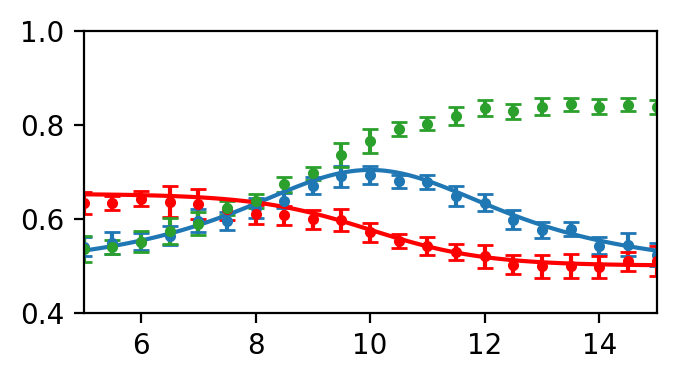

In [54]:
make_plot(seE2_comp, 2, N=200, ylim=(0.4, 1.0), show_comp=True)

9.97504160771568
0.0907556908941612


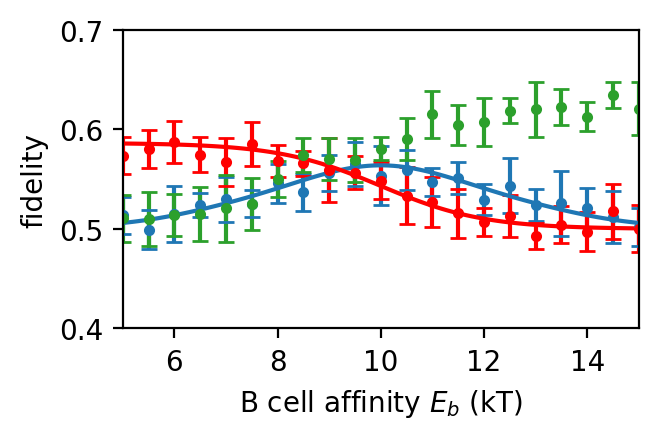

In [65]:
make_plot(seE2_comp_n20, 2, N=20, ylim=(0.4, 0.7), show_comp=True)

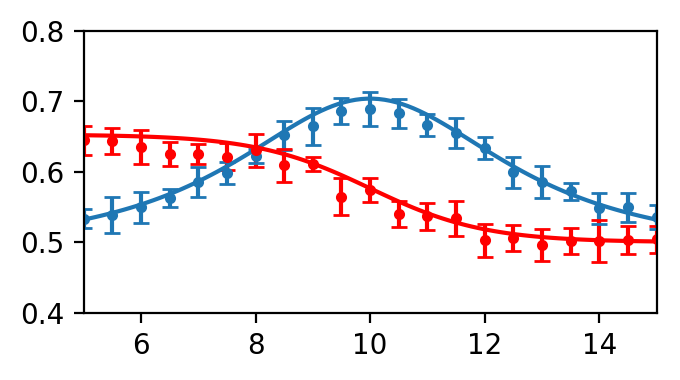

In [89]:
make_plot(seE2, 2, N=200, ylim=(0.4, 0.8))

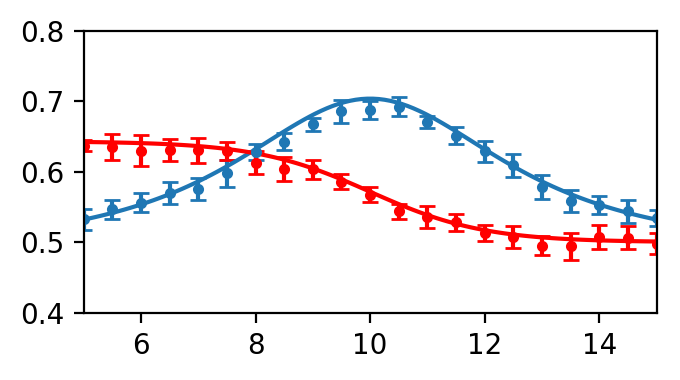

In [103]:
# import pickle
# with open("data/main_fig2", 'wb') as fp:
#     pickle.dump(seE2, fp)
make_plot(seE2, 2, N=200, ylim=(0.4, 0.8))

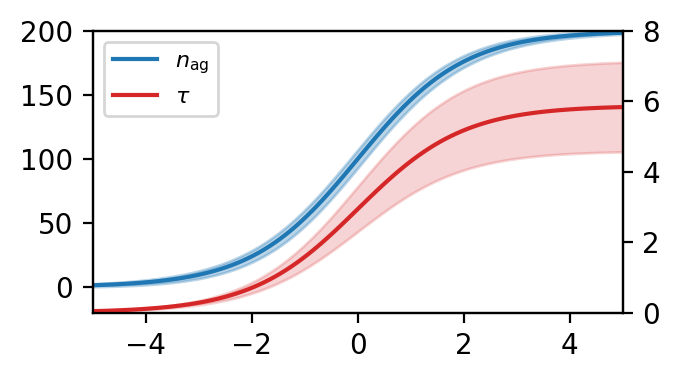

In [97]:
color1= "C0"
color2= "C3"
N = 200
fig, ax1 = plt.subplots(figsize=(3.5, 2), dpi=200)

delist= np.linspace(-5, 5, 100)
offset = 0

def get_lifetime(dE, f, n=100, xa=1.5, xb=2.0):
    tm, ts = 0, 0
    for i in range(1, n+1):
        tm += 1/(i* (np.exp(0 +f*xa/(i*kT)) + np.exp(-dE+f*xb/(i*kT) )))
        ts += 1/(i* (np.exp(0 +f*xa/(i*kT)) + np.exp(-dE+f*xb/(i*kT) )))**2
    return tm, np.sqrt(ts)

def get_antigen_num(dE, f, n=100, xa=1.5, xb=2.0):
    nag, nvar =0, 0
    for i in range(1, n+1):
        nag += np.exp(dE-f*(xb-xa)/(i*kT))/(np.exp(dE-f*(xb-xa)/(i*kT)) +1 )
        nvar += np.exp(dE-f*(xb-xa)/(i*kT))/(np.exp(dE-f*(xb-xa)/(i*kT)) +1 )**2
    return nag, np.sqrt(nvar)

tmean = np.asarray([get_lifetime(de, 0, N)[0] for de in delist])#/get_lifetime(100, 0, 100)[0]
tstd = np.asarray([get_lifetime(de, 0, N)[1] for de in delist])#/get_lifetime(100, 0, 100)[0]
nmean = N*np.exp(delist)/(1+np.exp(delist))
nstd = np.sqrt(N*np.exp(delist)/(1+np.exp(delist))**2)


ax1.plot(delist+offset, nmean, color=color1)
ax1.fill_between(delist+offset, nmean-nstd, nmean+nstd, color=color1, alpha=0.3)
ax1.plot([-6], [-1], color=color2)
tx = ax1.twinx()
tx.plot(delist+offset, tmean, color=color2)
tx.fill_between(delist+offset, tmean-tstd, tmean+tstd, color=color2, alpha=0.2)
ax1.set_xlim(-5+offset, 5+offset)
ax1.legend([r"$n_{\rm ag}$", r"$\tau$"], fontsize=8, loc=2)
#ax1.set_ylabel("antigen extraction")
ax1.set( ylim=(-20, 200))

#tx.set_ylabel("scaled cluster lifetime")
tx.set(ylim=(0, 8))
plt.tight_layout()
plt.savefig("figs/main_fig2/fig2A_n200.pdf", format='pdf')
plt.show()



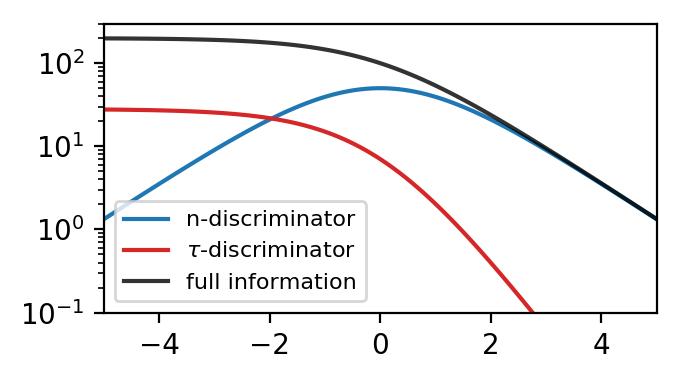

In [100]:
fig, ax1 = plt.subplots(figsize=(3.5, 2), dpi=200)

delist= np.linspace(-5, 5, 100)
offset = 0
Fisher_info_t = (np.log(N))**2/(1+np.exp(delist))**2
Fisher_info_n = N*np.exp(delist)/(1+np.exp(delist))**2
Fisher_info_all = N/(1+np.exp(delist))

ax1.plot(delist+offset, Fisher_info_n, color=color1)
ax1.plot(delist+offset, Fisher_info_t, color=color2)
ax1.plot(delist+offset, Fisher_info_all, color="k", alpha=0.8)
#ax1.fill_between(delist, Fisher_info_all, color="gray", alpha=0.1)
#ax1.fill_between(delist, Fisher_info_n, color=color1, alpha=0.2)
#ax1.fill_between(delist, Fisher_info_t, color=color2, alpha=0.2)

ax1.set_ylim(0.1, 300)
ax1.set_xlim(-5+offset, 5+offset)
#ax1.set_yticks([0, 10,20,30,40])
ax1.legend(["n-discriminator", r"$\tau$-discriminator", r'full information'], fontsize=8)
#ax1.set(xlabel="background BCR affinity, $E_b$, [k$_B$T]")
#ax1.set(ylabel="Fisher info., [(k$_B$T)$^{-2}$]")

# tx = ax1.twinx()
# tx.errorbar(np.asarray(seE10.prmlist)-5, seE10.nerror_list, fmt='oC0')
# tx.errorbar(np.asarray(seE10.prmlist)-5, seE10.terror_list, fmt='or')
# n=10
# plt.ylim(0.1, np.sqrt((1-1/n)**2/(2*n-1)*40)*0.3+0.1 )
plt.yscale('log')
plt.tight_layout()
plt.savefig("figs/main_fig2/fig2B_N200.pdf", format='pdf')
plt.show()



